Importing datasets and libraries



In [1]:
!pip install tensorflow

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import os
import PIL

In [3]:
# Check the number of images in training, validation and test dataset
train = []
test = []
path='/Users/priyarajpurohit/Desktop/Explainable AI/'

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir(path+'seg_train'):
  
  train_class = os.listdir(os.path.join(path+'seg_train', i))
  
  train.extend(train_class)
for i in os.listdir(path+'seg_test'):
  test_class = os.listdir(path+os.path.join('seg_test', i))
  test.extend(test_class)
print('Number of train images:{}\n Number of test images: {}'.format(len(train),len(test)))

Number of train images:14034
 Number of test images: 3000


Data Visulaization and Exploration

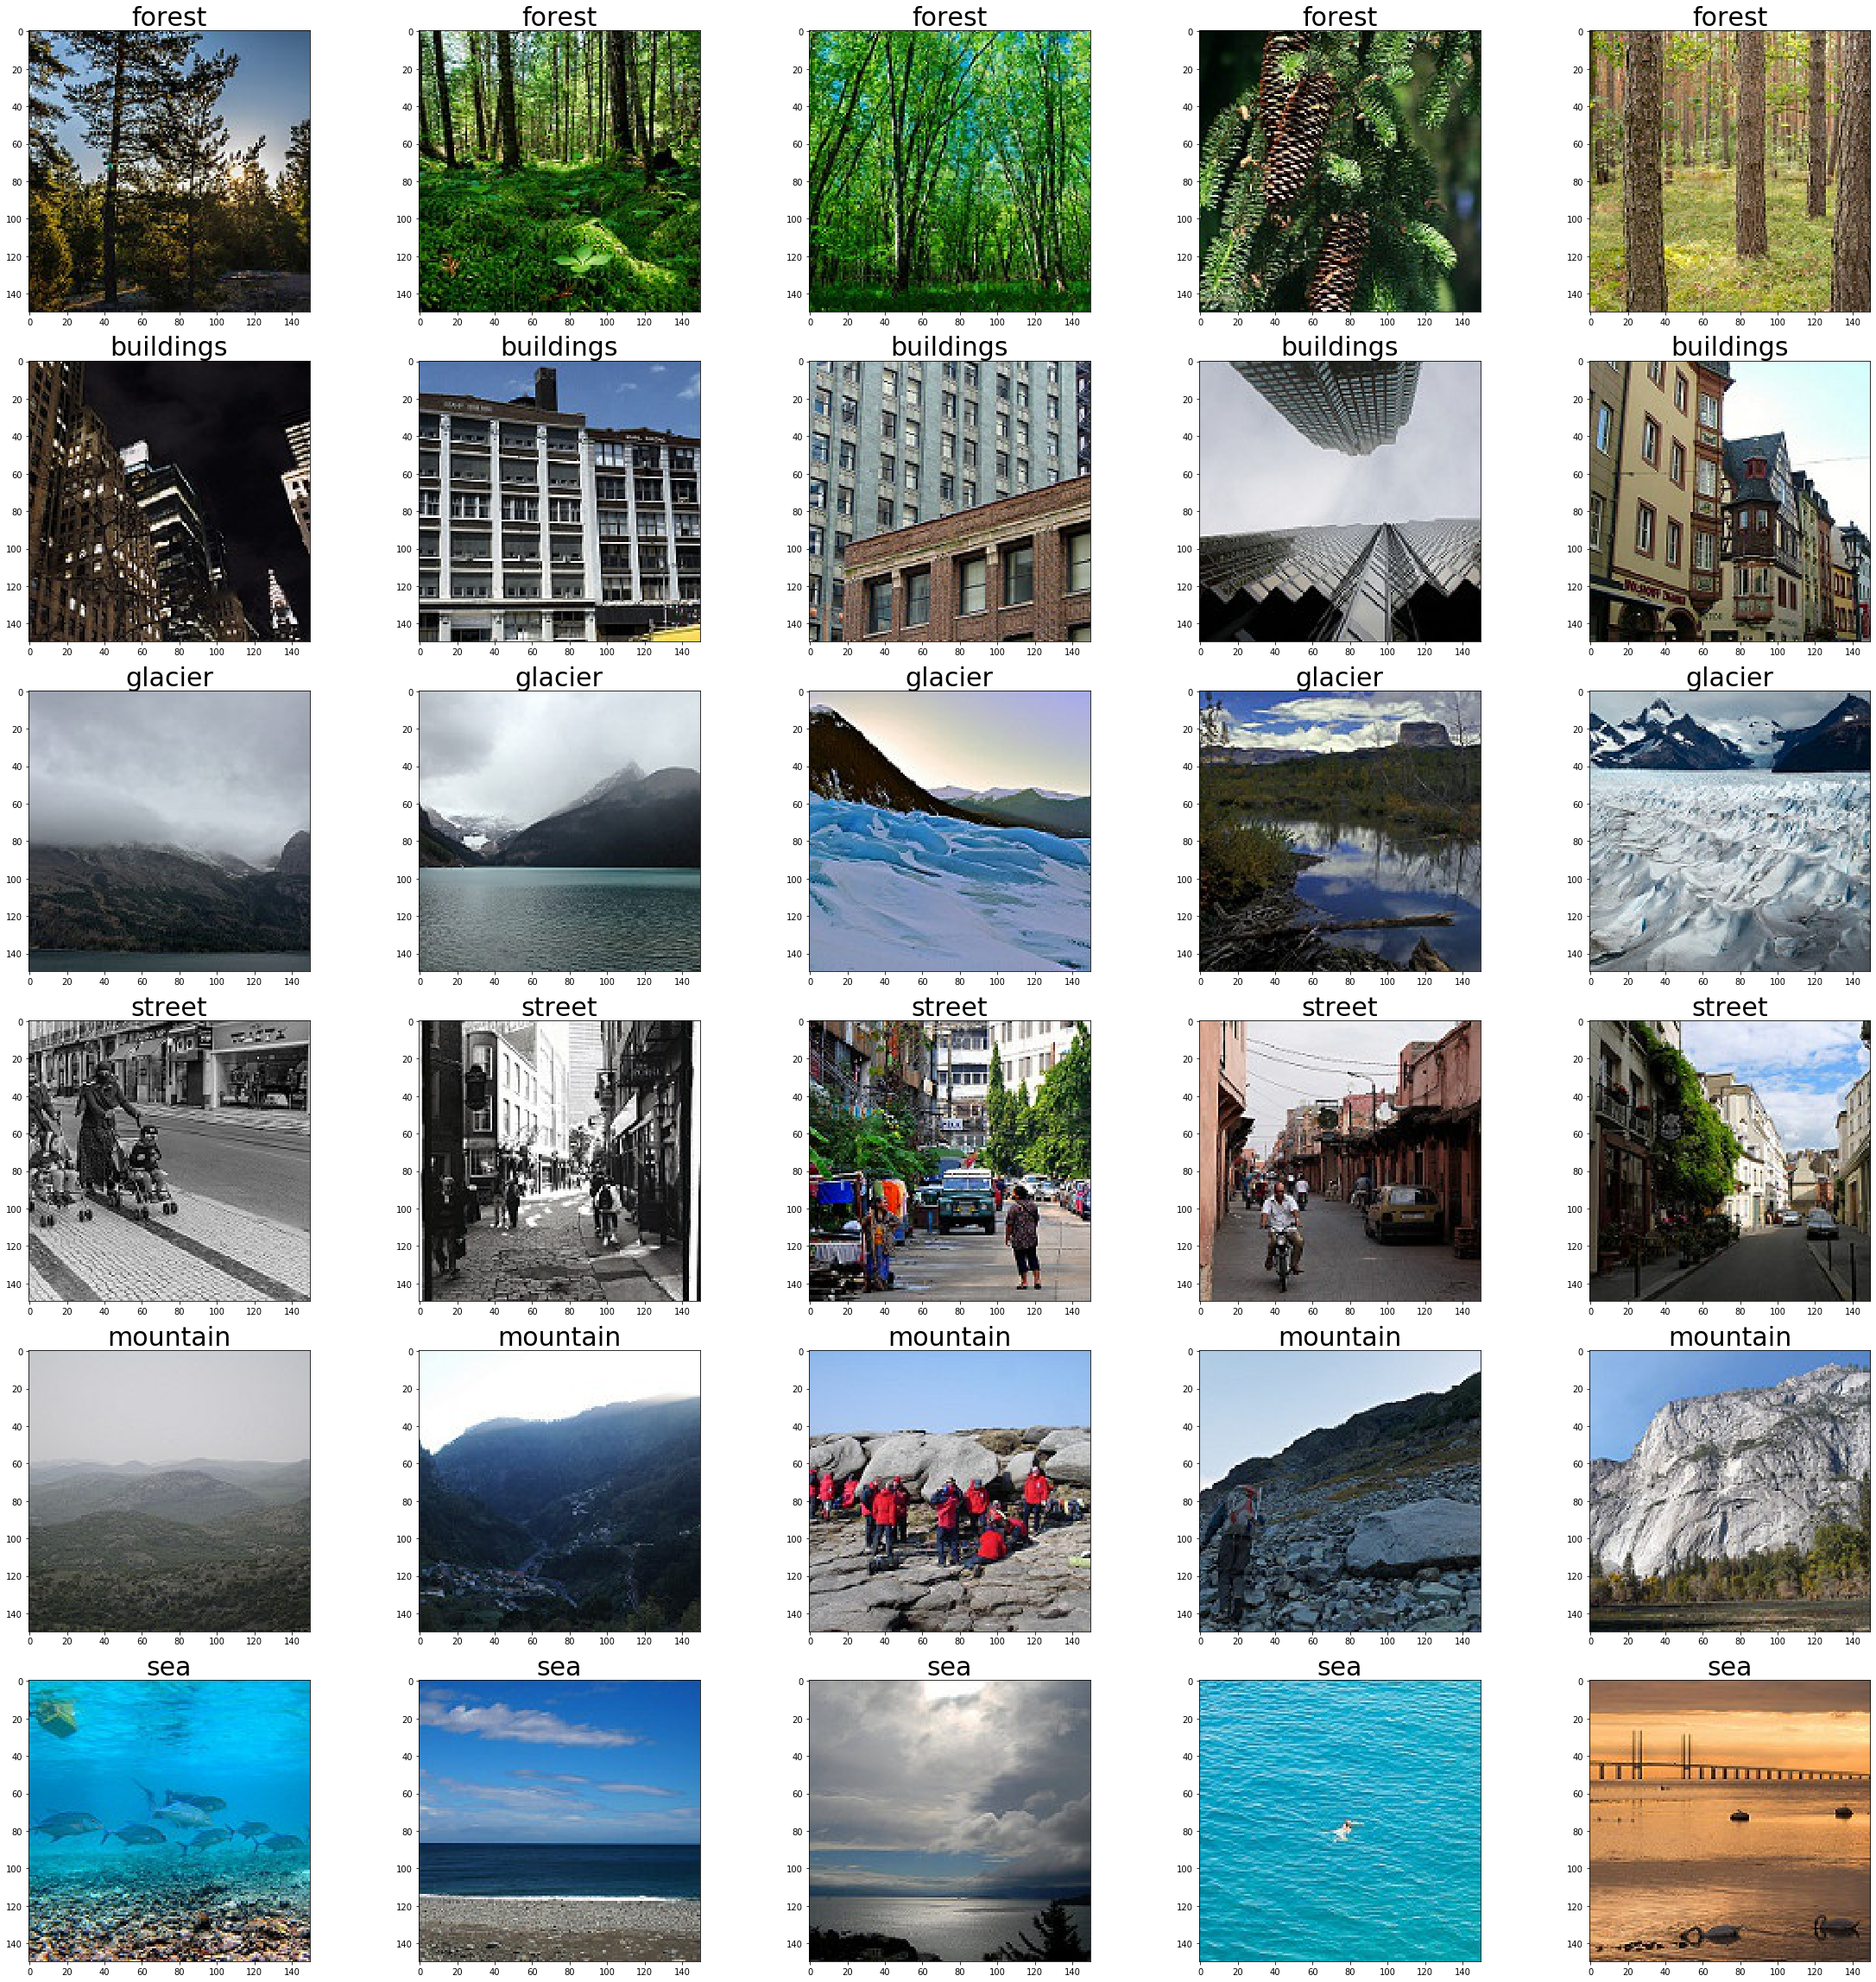

In [4]:
#Visualizing the dataset
fig, axs = plt.subplots(6,5, figsize=(32,32))
count = 0
for i in os.listdir(path+'seg_train'):
  # get the list of images in the particular class
  train_class = os.listdir(os.path.join(path+'seg_train',i))
  # plot 5 images per class
  for j in range(5):
        img=os.path.join(path+'seg_train',i,train_class[j])
        img=PIL.Image.open(img)
        axs[count][j].imshow(img)
        axs[count][j].set_title(i, fontsize=30)
  count+=1
fig.tight_layout()


Number of images in forest = 2271 

Number of images in buildings = 2191 

Number of images in glacier = 2404 

Number of images in street = 2382 

Number of images in mountain = 2512 

Number of images in sea = 2274 



<function matplotlib.pyplot.show(*args, **kw)>

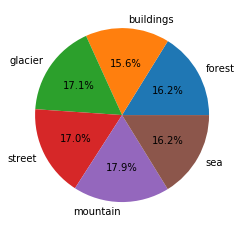

In [5]:
# check if training dataset is balanced

No_images_per_class = []
Class_name = []
for i in os.listdir(path+'seg_train'):
  train_class = os.listdir(os.path.join(path+'seg_train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

# plot pie chart
fig1,ax1=plt.subplots()
ax1.pie(No_images_per_class,labels=Class_name, autopct='%1.1f%%')
plt.show

Number of images in forest = 474 

Number of images in buildings = 437 

Number of images in glacier = 553 

Number of images in street = 501 

Number of images in mountain = 525 

Number of images in sea = 510 



<function matplotlib.pyplot.show(*args, **kw)>

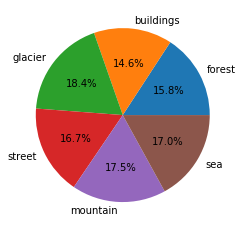

In [6]:
# check if testing dataset is balanced

No_images_per_class1 = []
Class_name1 = []
for i in os.listdir(path+'seg_test'):
  test_class = os.listdir(os.path.join(path+'seg_test', i))
  No_images_per_class1.append(len(test_class))
  Class_name1.append(i)
  print('Number of images in {} = {} \n'.format(i, len(test_class)))

# plot pie chart
fig1,ax1=plt.subplots()
ax1.pie(No_images_per_class1,labels=Class_name1, autopct='%1.1f%%')
plt.show

Data Augmentation and Building Data Generator

In [7]:
# create run-time augmentation on training and test dataset
# For training datagenerator, we add normalization, shear angle, zooming range ,vertical and horizontal flip
train_datagen=ImageDataGenerator(
                rescale=1./255,
                zoom_range=0.2,
                validation_split=0.15,
                horizontal_flip=True)


# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Creating datagenerator for training, validation and test dataset.

train_generator = train_datagen.flow_from_directory(path+'seg_train',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        subset ='training')

validation_generator = train_datagen.flow_from_directory(path+'seg_train',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        subset ='validation')
test_generator = test_datagen.flow_from_directory(path+'seg_test',
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')


Found 11932 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Training ResNet 18

In [9]:
def res_block(X, filter, stage):
  
  # Convolutional_block
  X_copy = X

  f1 , f2, f3 = filter
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [10]:

input_shape = (256,256,3)

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2- stage
X = res_block(X, filter= [64,64,256], stage= 2)

# 3- stage
X = res_block(X, filter= [128,128,512], stage= 3)

# 4- stage
X = res_block(X, filter= [256,256,1024], stage= 4)

# 5- stage
X = res_block(X, filter= [512,512,2048], stage= 5)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X=Dropout(0.4)(X)
X = Dense(6, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)


model = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model.summary()

Model: "Resnet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [11]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
num=train_generator.n//32
num1=validation_generator.n // 32
print(num,num1)

372 65


In [13]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath=path+"weights.hdf5", verbose=1, save_best_only=True)

In [14]:
history=model.fit(
        train_generator,
        steps_per_epoch=num,
        epochs=10,
        batch_size=32,
        validation_data=validation_generator,
        validation_steps=num1,
        callbacks=[checkpointer , earlystopping])

Epoch 1/10
372/372 [==============================] - ETA: 0s - loss: 1.2322 - accuracy: 0.5893
Epoch 00001: val_loss improved from inf to 1.71357, saving model to /Users/priyarajpurohit/Desktop/Explainable AI/weights.hdf5
372/372 [==============================] - 1333s 4s/step - loss: 1.2322 - accuracy: 0.5893 - val_loss: 1.7136 - val_accuracy: 0.4630
Epoch 2/10
372/372 [==============================] - ETA: 0s - loss: 0.7180 - accuracy: 0.7427
Epoch 00002: val_loss improved from 1.71357 to 0.97564, saving model to /Users/priyarajpurohit/Desktop/Explainable AI/weights.hdf5
372/372 [==============================] - 1393s 4s/step - loss: 0.7180 - accuracy: 0.7427 - val_loss: 0.9756 - val_accuracy: 0.6322
Epoch 3/10
372/372 [==============================] - ETA: 0s - loss: 0.6293 - accuracy: 0.7779
Epoch 00003: val_loss did not improve from 0.97564
372/372 [==============================] - 1386s 4s/step - loss: 0.6293 - accuracy: 0.7779 - val_loss: 1.0016 - val_accuracy: 0.6322
Epoc

 Assessing the performance of model on dataset

In [15]:
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 32, verbose =1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
93/93 [==============================] - 58s 627ms/step - loss: 0.5913 - accuracy: 0.7843


In [16]:
# assign label names to the corresponding indexes
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3:'mountain', 4: 'sea', 5:'street'}

In [17]:
# load images and their predictions 

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import cv2

prediction = []
original = []
image = []
count = 0
for i in os.listdir(path+'seg_test'):
    for item in os.listdir(os.path.join(path+'seg_test', i)):
        # code to open the image
        img= PIL.Image.open(os.path.join(path+'seg_test', i, item))
        # resizing the image to (256,256)
        img = img.resize((256, 256))
        # appending image to the image list
        image.append(img)
        # converting image to array
        img = np.asarray(img, dtype = np.float32)
        # normalizing the image
        img = img / 255
        # reshaping the image into a 4D array
        img = img.reshape(-1, 256, 256, 3)
        # making prediction of the model
        predict = model.predict(img)
        # getting the index corresponding to the highest value in the prediction
        predict = np.argmax(predict)
        # appending the predicted class to the list
        prediction.append(labels[predict])
        # appending original class to the list
        original.append(i)


In [18]:
# Get the test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.7856666666666666


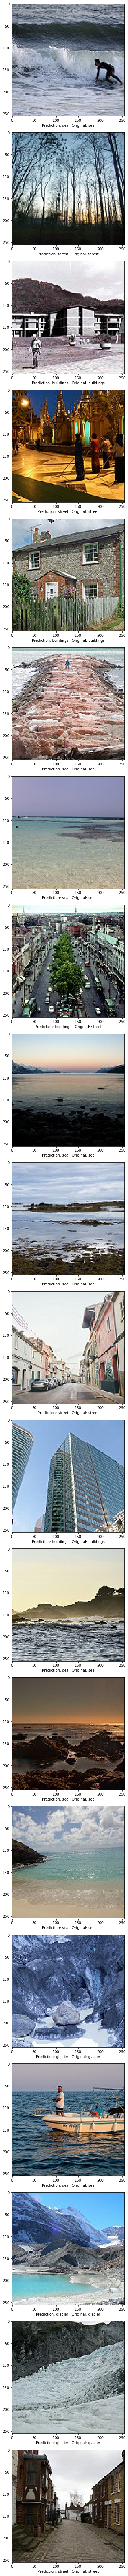

In [24]:
# visualize the results
import random
fig = plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0, len(image))
    fig.add_subplot(20, 1, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

Visualizing Activation Map through GRAD-CAM

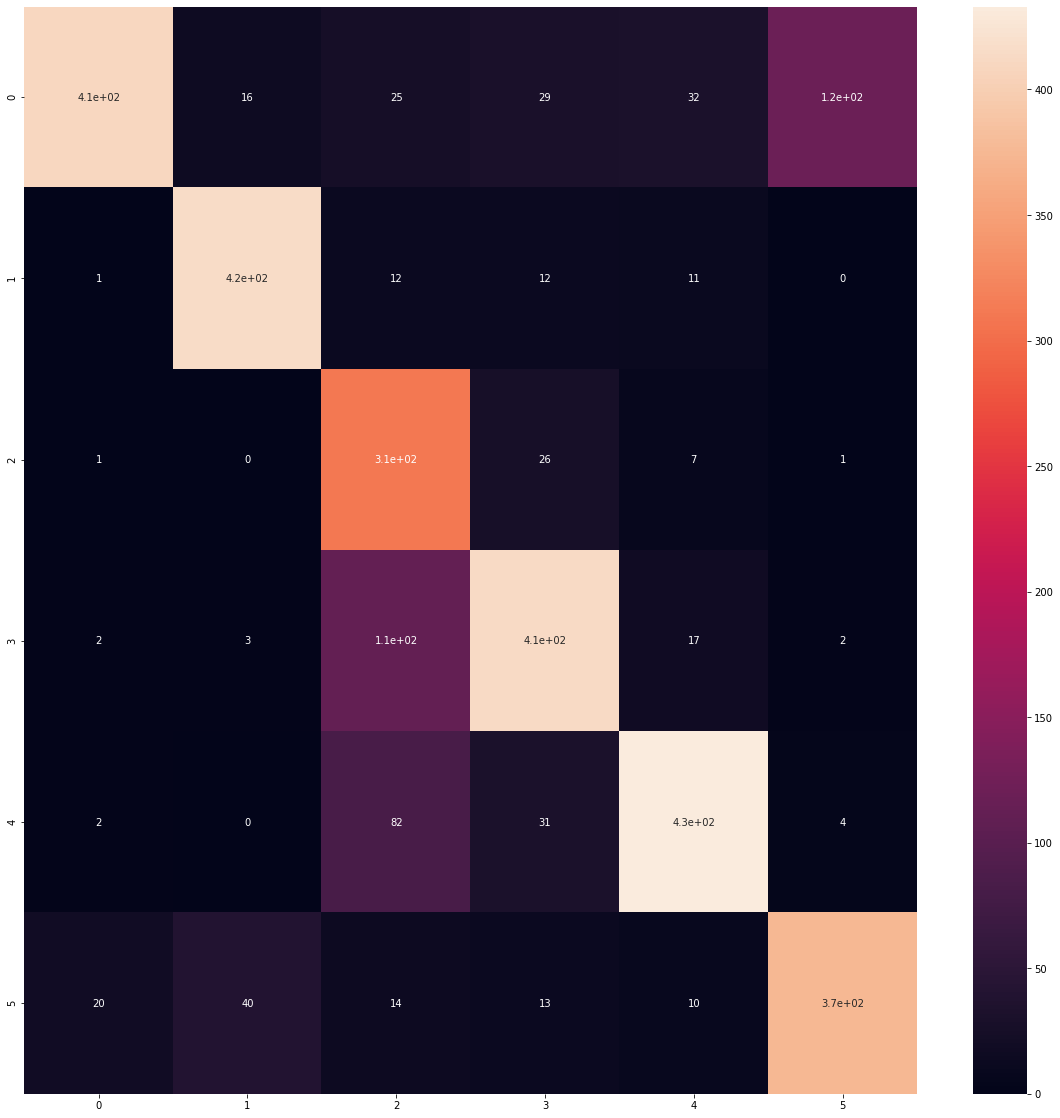

In [25]:
#heatmap
plt.figure(figsize=(20,20))
cm=confusion_matrix(np.asarray(prediction),np.asarray(original))
sns.heatmap(cm,annot=True)

In [26]:
def grad_cam(img):

  # Convert the image to array of type float32
  img = np.asarray(img, dtype = np.float32)

  # Reshape the image from (256,256,3) to (1,256,256,3)
  img = img.reshape(-1, 256, 256, 3)
  img_scaled = img / 255

  # Name of the average pooling layer and dense final (you can see these names in the model summary)
  classification_layers = ["Averagea_Pooling", "Dense_final"]

  # Last convolutional layer in the model
  final_conv = model.get_layer("res_5_identity_2_c")

  # Create a model with original model inputs and the last conv_layer as the output
  final_conv_model = keras.Model(model.inputs, final_conv.output)

  # Then we create the input for classification layer, which is the output of last conv layer
  # In our case, output produced by the conv layer is of the shape (1,3,3,2048) 
  # Since the classification input needs the features as input, we ignore the batch dimension

  classification_input = keras.Input(shape = final_conv.output.shape[1:])

  # We iterate through the classification layers, to get the final layer and then append 
  # the layer as the output layer to the classification model.
  temp = classification_input
  for layer in classification_layers:
      temp = model.get_layer(layer)(temp)
  classification_model = keras.Model(classification_input, temp)


  # We use gradient tape to monitor the 'final_conv_output' to retrive the gradients
  # corresponding to the predicted class
  with tf.GradientTape() as tape:
      # Pass the image through the base model and get the feature map 
      final_conv_output = final_conv_model(img_scaled)

      # Assign gradient tape to monitor the conv_output
      tape.watch(final_conv_output)
      
      # Pass the feature map through the classification model and use argmax to get the 
      # index of the predicted class and then use the index to get the value produced by final
      # layer for that class
      prediction = classification_model(final_conv_output)

      predicted_class = tf.argmax(prediction[0][0][0])

      predicted_class_value = prediction[:,:,:,predicted_class]
  
  # Get the gradient corresponding to the predicted class based on feature map.
  # which is of shape (1,3,3,2048)
  gradient = tape.gradient(predicted_class_value, final_conv_output)

  # Since we need the filter values (2048), we reduce the other dimensions, 
  # which would result in a shape of (2048,)
  gradient_channels = tf.reduce_mean(gradient, axis=(0, 1, 2))

  # We then convert the feature map produced by last conv layer(1,6,6,1536) to (6,6,1536)
  final_conv_output = final_conv_output.numpy()[0]

  gradient_channels = gradient_channels.numpy()

  # We multiply the filters in the feature map produced by final conv layer by the 
  # filter values that are used to get the predicted class. By doing this we inrease the
  # value of areas that helped in making the prediction and lower the vlaue of areas, that 
  # did not contribute towards the final prediction
  for i in range(gradient_channels.shape[-1]):
      final_conv_output[:, :, i] *= gradient_channels[i]

  # We take the mean accross the channels to get the feature map
  heatmap = np.mean(final_conv_output, axis=-1)

  # Normalizing the heat map between 0 and 1, to visualize it
  heatmap_normalized = np.maximum(heatmap, 0) / np.max(heatmap)

  # Rescaling and converting the type to int
  heatmap = np.uint8(255 * heatmap_normalized )

  # Create the colormap
  color_map = plt.cm.get_cmap('jet')

  # get only the rb features from the heatmap
  color_map = color_map(np.arange(256))[:, :3]
  heatmap = color_map[heatmap]

  # convert the array to image, resize the image and then convert to array
  heatmap = keras.preprocessing.image.array_to_img(heatmap)
  heatmap = heatmap.resize((256, 256))
  heatmap = np.asarray(heatmap, dtype = np.float32)

  # Add the heatmap on top of the original image
  final_img = heatmap * 0.3 + img[0]
  final_img = keras.preprocessing.image.array_to_img(final_img)

  return final_img, heatmap_normalized


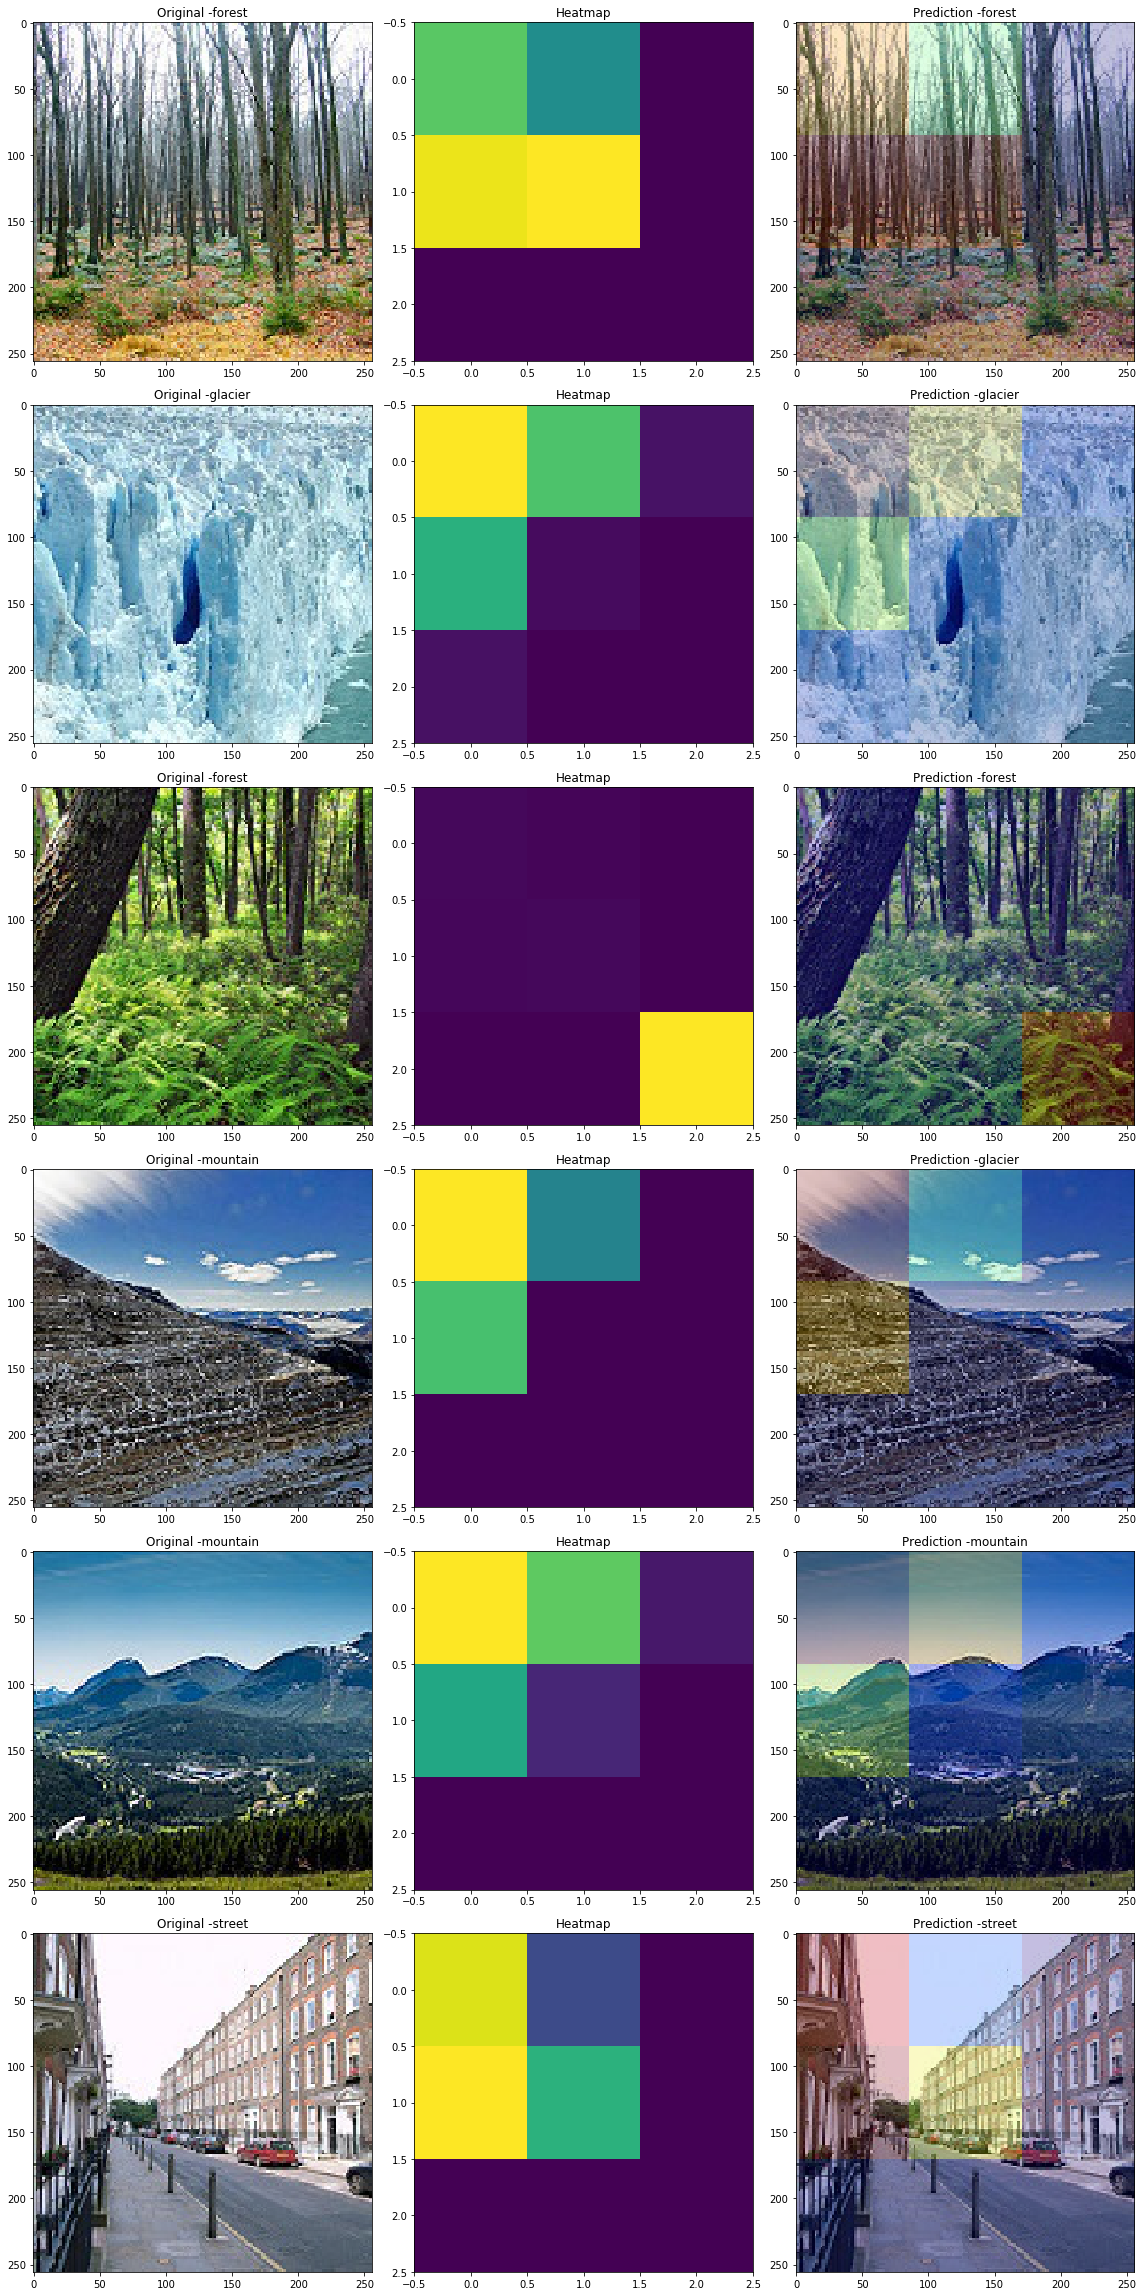

In [27]:
# Visualize the images in the dataset
import random
fig, axs = plt.subplots(6,3, figsize = (16,32))
count = 0
for _ in range(6):
  i = random.randint(0, len(image))
  gradcam, heatmap = grad_cam(image[i])
  axs[count][0].title.set_text("Original -" + original[i])
  axs[count][0].imshow(image[i])
  axs[count][1].title.set_text("Heatmap") 
  axs[count][1].imshow(heatmap)
  axs[count][2].title.set_text("Prediction -" + prediction[i]) 
  axs[count][2].imshow(gradcam)  
  count += 1

fig.tight_layout()